
%load_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from fgbuster import CMB, Dust, Synchrotron, MixingMatrix
from fgbuster.observation_helpers import standardize_instrument, get_observation
from fgbuster.cosmology import _get_Cl_cmb
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import healpy as hp
import numdifftools as nd
import math as m

In [2]:
instr = np.load('/Users/alicepirotta/Desktop/APC/MCMC/instrument_LB_IMOv1.npy', allow_pickle=True).item()
instr_ = {}
instr_['frequency'] = np.array([instr[f]['freq'] for f in instr.keys()])
instr_['depth_p'] = np.array([instr[f]['P_sens'] for f in instr.keys()])
instr_['fwhm'] = np.array([instr[f]['beam'] for f in instr.keys()])
instr_['depth_i'] = instr_['depth_p']/np.sqrt(2)
instrument = standardize_instrument(instr_)

In [3]:
nside = 64
freq_maps_N = get_observation(instrument, 'd0s0', noise=True, nside=nside)[:,1:,:]
freq_maps = get_observation(instrument, 'd0s0', noise=False, nside=nside)[:,1:,:]

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [4]:
components= [CMB(), Dust(50.), Synchrotron(50.)]

In [5]:
A = MixingMatrix(*components)
A_ev = A.evaluator(instrument.frequency)
N = np.eye(len(instrument.frequency)) 
invN = np.diag((hp.nside2resol(nside, arcmin=True) / instrument.depth_p)**2)

In [6]:

x1 = np.array([1.3,19,-2.5, 0.8,1.3])

(3, 3)
(3, 2, 49152)
(3, 3)
(3, 2, 49152)
(3, 3)
(3, 2, 49152)
(3, 3)
(3, 2, 49152)
(3, 3)
(3, 2, 49152)
(3, 3)
(3, 2, 49152)
(3, 3)
(3, 2, 49152)
(3, 3)
(3, 2, 49152)
(3, 3)
(3, 2, 49152)
(3, 3)
(3, 2, 49152)
351047475.8450112
5.337244184371922e-05


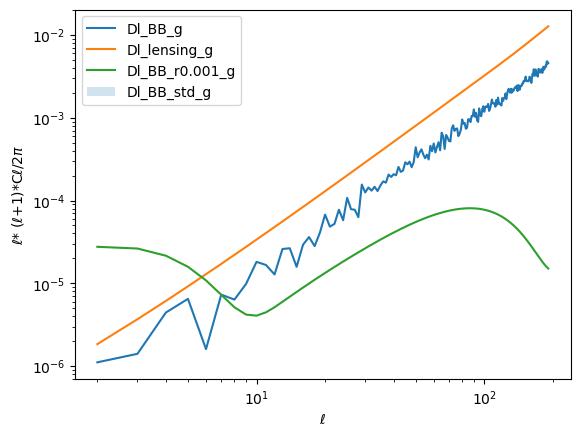

In [7]:
Cl_all_g = []
seeds = 10
for i in range (seeds):
    np.random.seed(i)
    

    def spectral_likelihood(y):
        Bd, T, Bs, a, c = y
        b = 1
        G = np.diag([a,a,a,a,a,a,a,b,b,b,b,b,b,b,b,c,c,c,c,c,c,c])
        invNd = np.einsum('ij,jsp->isp', invN, freq_maps_N)
        A_maxL =G.dot(A_ev(np.array([Bd,T,Bs]))) 
        logL = 0
        AtNd= np.einsum('ji,jsp->isp', A_maxL, invNd)
        AtNA = np.linalg.inv(A_maxL.T.dot(invN).dot(A_maxL))
        logL = logL + np.einsum('isp,ij,jsp->', AtNd, AtNA, AtNd)
        if logL != logL:
            return 0.0
        return -logL

    min_= minimize (spectral_likelihood, x1, method='Nelder-Mead')
  
 
    a = min_.x[3]
    b= 1
    c = min_.x[4]
    G = np.diag([a,a,a,a,a,a,a,b,b,b,b,b,b,b,b,c,c,c,c,c,c,c])  
    invNd = np.einsum('ij,jsp->isp', invN, freq_maps_N)
    A_maxL =G.dot(A_ev(min_.x)) 

    AtNd= np.einsum('ji,jsp->isp', A_maxL, invNd)
    AtNA = np.linalg.inv(A_maxL.T.dot(invN).dot(A_maxL))
    print(AtNA.shape)
    print(AtNd.shape)


    s = np.einsum('cg,gsp->csp', AtNA,AtNd)
    s = s[0]
    zeros=np.zeros((1, 49152))
    unione = np.vstack((zeros, s))
    
    
    Cl =hp.anafast(unione)[2,2:]
    Cl_all_g.append(Cl)
 

Cl_all_g=np.array(Cl_all_g)
Cl_mean_g=np.mean(Cl_all_g, axis=0) 
Cl_std_g = np.std(Cl_all_g, axis=0)



ell = np.arange(2,192)
Dl_mean_g = (ell*(ell+1)*Cl_mean_g)/(2*m.pi)
Dl_std_g = (ell*(ell+1)*Cl_std_g)/(2*m.pi)




Cl_BB_r1 = _get_Cl_cmb(Alens=0.0, r=1.)[2][2:192]
Cl_BB_r001 = _get_Cl_cmb(Alens=0.0, r=0.001)[2][2:192]
Dl_BB = (ell*(ell+1)*Cl_BB_r001)/(2*m.pi)

Cl_lens = _get_Cl_cmb(Alens=1.0, r=0.)[2][2:192]
Dl_lens = (ell*(ell+1)*Cl_lens)/(2*m.pi)

Data_g = Cl_mean_g + Cl_lens
fsky = 1
F_g = np.sum((2*ell+1) * fsky / 2*Cl_BB_r1** 2 / Data_g ** 2)
sigma_r_fisher_g = np.sqrt(1.0 / F_g)
print(F_g)
print(sigma_r_fisher_g)





plt.loglog(ell, Dl_mean_g, label = "Dl_BB_g")
plt.loglog(ell, Dl_lens, label = "Dl_lensing_g")
plt.loglog(ell, Dl_BB, label = "Dl_BB_r0.001_g")
plt.fill_between(ell,Dl_mean_g+Dl_std_g, Dl_mean_g-Dl_std_g, alpha=0.2, label="Dl_BB_std_g")



plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell$* ($\ell$+1)*C$\ell$/2$\pi$')
plt.legend()


Now I want to do the same using the averaged likelihood, where I don't need to do the cicle for 10 noise realization (right?).
In this I avoid the choice to do that:
freq_maps = get_observation(instrument, 'd0s0', noise=True, nside=nside)[:,1:,:]
using all the freq_maps..  
If I did this I have some dimensions problems in the part where I add the "zeros" again.  


In [8]:
dati = np.einsum('ijp,klp-> ijkl',freq_maps,freq_maps)
print(dati.shape)


(22, 2, 22, 2)


(2, 49152)
(190,)
838025028.8295424
3.454391092918724e-05


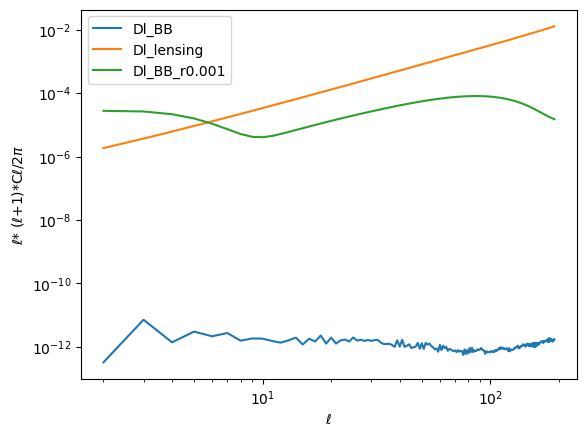

In [9]:

def aver_likelihood(y):
    Bd, T, Bs, a, c = y
    b= 1
    G = np.diag([a, a, a, a, a, a, a, a, b, b, b, b, b, b, c, c, c, c, c, c, c, c ])
    A_maxL =G.dot(A_ev(np.array([Bd,T,Bs]))) 
    logL = 0
    AtN = A_maxL.T.dot(invN)
    NA= invN.dot(A_maxL)
    AtNA = np.linalg.inv(A_maxL.T.dot(invN).dot(A_maxL))
    P = NA.dot(AtNA).dot(AtN)
    logL = logL -np.trace(np.einsum('fg, gikj->fk', P, dati)+np.einsum('fg, ij->gi', P, N))

    if logL != logL:
        return 0.0
    return logL

min_= minimize (aver_likelihood, x1, method='Nelder-Mead')
   
    
      
A_maxL =A_ev(min_.x) 
AtN = A_maxL.T.dot(N)
AtNA = np.linalg.inv(A_maxL.T.dot(N).dot(A_maxL))

s = np.einsum('cg,gs,sij->cij',AtNA,AtN,freq_maps)
s = s[0]
print(s.shape)
 
zeros=np.zeros((1, 49152))
unione = np.vstack((zeros, s))
        
   
    
Cl =hp.anafast(unione)[2,2:] 
print(Cl.shape)  
 


ell = np.arange(2,192)
Dl_mean = (ell*(ell+1)*Cl)/(2*m.pi)



Cl_BB_r1 = _get_Cl_cmb(Alens=0.0, r=1.)[2][2:192]
Cl_BB_r_001 = _get_Cl_cmb(Alens=0.0, r=0.001)[2][2:192]
Dl_BB = (ell*(ell+1)*Cl_BB_r_001)/(2*m.pi)

Cl_lens = _get_Cl_cmb(Alens=1.0, r=0.)[2][2:192]
Dl_lens = (ell*(ell+1)*Cl_lens)/(2*m.pi)


Data = Cl + Cl_lens
fsky = 1
F = np.sum((2*ell+1) * fsky / 2*Cl_BB_r1** 2 / Data ** 2)
sigma_r_fisher = np.sqrt(1.0 / F)
print(F)
print(sigma_r_fisher)



plt.loglog(ell, Dl_mean, label = "Dl_BB")
plt.loglog(ell, Dl_lens, label = "Dl_lensing")
plt.loglog(ell, Dl_BB, label = "Dl_BB_r0.001")




plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell$* ($\ell$+1)*C$\ell$/2$\pi$')
plt.legend()



    
